# Feature Engineering Test Notebook

This notebook tests **ALL** features defined in `ENGINEERED_FEATURES` from the config file.

## Structure:
1. **Data Loading** - Load raw data
2. **Data Cleaning** - Clean data without dropping columns (only missing value handling, emp_length cleaning, business constraints)
3. **Post-Cleaning Visualizations** - Analysis of cleaned data
4. **Feature Engineering** - Create ALL engineered features from config
5. **Post-Engineering Visualizations** - Detailed analysis and visualizations for each feature
6. **Correlation Analysis** - Correlation analysis of all features
7. **Feature Importance Analysis** - Feature importance analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath('')))

import config
import data_cleaning
import feature_engineering
import eda

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

print("=" * 80)
print("FEATURE ENGINEERING TEST - TEST ALL FEATURES")
print("=" * 80)
print(f"\nTotal engineered features in config: {len(config.ENGINEERED_FEATURES)}")
print(f"Features to test: {list(config.ENGINEERED_FEATURES.keys())[:10]}...")  # Show first 10


FEATURE ENGINEERING TEST - TEST ALL FEATURES

Total engineered features in config: 98
Features to test: ['DTI', 'Credit_Utilization', 'Payment_to_Income_Ratio', 'Average_Credit_Line_Size', 'lti', 'debt_to_income', 'loan_to_income', 'utilization_rate', 'account_age_ratio', 'has_delinquency']...


## 1. Data Loading


In [2]:
df_raw = pd.read_excel(config.DATA_PATHS['raw_data'])
print(f"Dataset Shape: {df_raw.shape}")
print(f"Number of features: {df_raw.shape[1] - 1}")
print(f"Number of records: {df_raw.shape[0]}")

print("\nDataset Columns:")
print(df_raw.columns.tolist())

print("\nFirst few rows:")
df_raw.head()


Dataset Shape: (15000, 20)
Number of features: 19
Number of records: 15000

Dataset Columns:
['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'installment', 'emp_title', 'emp_length', 'annual_inc', 'delinq_2yrs', 'open_acc', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_amnt', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'default']

First few rows:


id member_id  loan_amnt  funded_amnt  funded_amnt_inv  term  installment  \
0   1  M0000001    16795.0      16505.0          15094.0    36        32.66   
1   2  M0000002     1860.0       1848.0           1494.0    60         2.17   
2   3  M0000003    39158.0      37619.0          34683.0    36        76.14   
3   4  M0000004    12284.0      12266.0          11096.0    60        14.33   
4   5  M0000005     7265.0       6953.0           6651.0    60         8.48   

        emp_title emp_length  annual_inc  delinq_2yrs  open_acc  total_acc  \
0  Data Scientist    9 years    228362.0          0.0       6.0       12.0   
1       Developer    7 years    273685.0          1.0      14.0       20.0   
2         Manager     1 year    165933.0          0.0      11.0       17.0   
3         Manager    9 years    136818.0          0.0       7.0       16.0   
4         Analyst    2 years    114755.0          0.0      13.0       15.0   

   total_pymnt  total_pymnt_inv  last_pymnt_amnt  tot_coll_amt  tot_cur_bal  \
0      1459.92          1377.66            39.12         191.0      30634.0   
1       137.61           133.20             1.74          60.0     158169.0   
2      2688.63          2460.36            77.56          65.0      66504.0   
3       980.01           907.17            13.45          50.0     101207.0   
4       513.38           508.43             8.86          88.0     108914.0   

   total_rev_hi_lim  default  
0           13996.0        0  
1           97196.0        0  
2           31634.0        0  
3           99850.0        0  
4           68794.0        0

## 2. Prepare Data (Without Dropping Columns)

**IMPORTANT:** In this test notebook, no columns will be dropped. Only the following will be applied:
- Missing value handling
- emp_length cleaning
- Business logic constraints


In [3]:
X = df_raw.drop(columns=['default']).copy()
y = df_raw['default'].copy()

print("=" * 80)
print("DATA CLEANING (WITHOUT DROPPING COLUMNS)")
print("=" * 80)
print(f"\nInitial number of columns: {X.shape[1]}")
print(f"Initial number of rows: {X.shape[0]}")

DATA CLEANING (WITHOUT DROPPING COLUMNS)

Initial number of columns: 19
Initial number of rows: 15000


In [4]:
EMPLOYMENT_LENGTH_MAP = {
    '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10
}

X['emp_length'] = X['emp_length'].astype(str).str.strip()
X['emp_length'] = X['emp_length'].replace(['nan', 'NaN', 'None', 'none', '', 'NaT'], np.nan)
X['emp_length'] = X['emp_length'].map(EMPLOYMENT_LENGTH_MAP).fillna(0).astype(int)

print("Cleaned emp_length")


Cleaned emp_length


In [5]:
X["emp_length"]

0         9
1         7
2         1
3         9
4         2
         ..
14995    10
14996     9
14997     8
14998    10
14999     7
Name: emp_length, Length: 15000, dtype: int64

In [6]:
print("\n2. Applying business logic constraints...")
constraints_applied = 0

if 'loan_amnt' in X.columns and 'funded_amnt' in X.columns:
    count = (X['funded_amnt'] > X['loan_amnt']).sum()
    if count > 0:
        X['funded_amnt'] = np.minimum(X['loan_amnt'], X['funded_amnt'])
        print(f"Fixed {count} rows where 'funded_amnt > loan_amnt'")
        constraints_applied += count

if 'funded_amnt' in X.columns and 'funded_amnt_inv' in X.columns:
    count = (X['funded_amnt_inv'] > X['funded_amnt']).sum()
    if count > 0:
        X['funded_amnt_inv'] = np.minimum(X['funded_amnt'], X['funded_amnt_inv'])
        print(f"Fixed {count} rows where 'funded_amnt_inv > funded_amnt'")
        constraints_applied += count

if 'total_pymnt' in X.columns and 'total_pymnt_inv' in X.columns:
    count = (X['total_pymnt_inv'] > X['total_pymnt']).sum()
    if count > 0:
        X['total_pymnt_inv'] = np.minimum(X['total_pymnt'], X['total_pymnt_inv'])
        print(f"Fixed {count} rows where 'total_pymnt_inv > total_pymnt'")
        constraints_applied += count

if 'total_pymnt' in X.columns and 'last_pymnt_amnt' in X.columns:
    count = (X['last_pymnt_amnt'] > X['total_pymnt']).sum()
    if count > 0:
        X['last_pymnt_amnt'] = np.minimum(X['total_pymnt'], X['last_pymnt_amnt'])
        constraints_applied += count

if constraints_applied == 0:
    print("No constraint violations found")


2. Applying business logic constraints...
No constraint violations found


In [7]:
print("\n3. Handling missing values...")
if 'emp_title' in X.columns:
    X['emp_title'] = X['emp_title'].fillna('Unknown')
    print("Filled emp_title missing values with 'Unknown'")

if 'delinq_2yrs' in X.columns:
    X['delinq_2yrs'] = X['delinq_2yrs'].fillna(0)
    print("Filled delinq_2yrs missing values with 0")


3. Handling missing values...
Filled emp_title missing values with 'Unknown'
Filled delinq_2yrs missing values with 0


In [8]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
missing_numeric = [col for col in numeric_cols if X[col].isna().any()]
if missing_numeric:
    for col in missing_numeric:
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
    print(f"Filled {len(missing_numeric)} numerical columns with median: {missing_numeric}")

print(f"\nData cleaning completed!")
print(f"Final number of columns: {X.shape[1]} (no columns dropped)")
print(f"Final number of rows: {X.shape[0]}")


Filled 13 numerical columns with median: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'open_acc', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_amnt', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

Data cleaning completed!
Final number of columns: 19 (no columns dropped)
Final number of rows: 15000


## 2.1 Post-Cleaning Visualizations


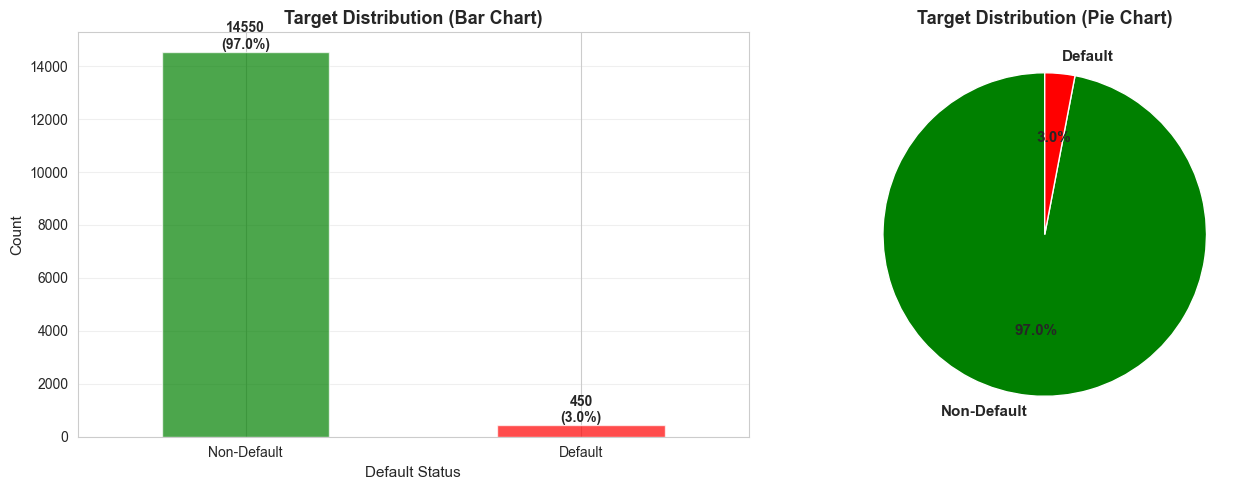


Target Distribution:
  - Non-Default: 14550 (97.00%)
  - Default: 450 (3.00%)


In [9]:
# Target distribution visualization
df_viz_cleaned = X.copy()
df_viz_cleaned['default'] = y.values

target_counts = y.value_counts()
target_percentages = y.value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

target_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Target Distribution (Bar Chart)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Default Status', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_xticklabels(['Non-Default', 'Default'], rotation=0)
axes[0].grid(alpha=0.3, axis='y')

for i, (idx, val) in enumerate(target_counts.items()):
    axes[0].text(i, val, f'{val}\n({target_percentages[idx]:.1f}%)', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

colors = ['green', 'red']
axes[1].pie(target_counts.values, labels=['Non-Default', 'Default'], 
            autopct='%1.1f%%', colors=colors, startangle=90,
            textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Target Distribution (Pie Chart)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTarget Distribution:")
print(f"  - Non-Default: {target_counts[0]} ({target_percentages[0]:.2f}%)")
print(f"  - Default: {target_counts[1]} ({target_percentages[1]:.2f}%)")


In [10]:
missing_data = X.isnull().sum()
missing_data = missing_data[missing_data > 0]

if len(missing_data) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    missing_data.plot(kind='bar', ax=ax, color='coral', alpha=0.7)
    ax.set_title('Missing Values After Cleaning', fontsize=13, fontweight='bold')
    ax.set_xlabel('Features', fontsize=11)
    ax.set_ylabel('Missing Count', fontsize=11)
    ax.grid(alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print(f"\nColumns with remaining missing values: {missing_data.to_dict()}")
else:
    print("\n✓ No missing values in any column!")



✓ No missing values in any column!


In [11]:
# Basic statistics for cleaned data
print("=" * 80)
print("CLEANED DATA STATISTICS")
print("=" * 80)

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumber of numerical features: {len(numeric_features)}")
print(f"Number of categorical features: {X.shape[1] - len(numeric_features)}")

print("\nNumerical Features:")
print(numeric_features)

print("\nCategorical Features:")
categorical_features = [col for col in X.columns if col not in numeric_features]
print(categorical_features)

# Show basic statistics
print("\n\nBasic Statistics for Numerical Features:")
X[numeric_features].describe()


CLEANED DATA STATISTICS

Number of numerical features: 17
Number of categorical features: 2

Numerical Features:
['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'installment', 'emp_length', 'annual_inc', 'delinq_2yrs', 'open_acc', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_amnt', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

Categorical Features:
['member_id', 'emp_title']


Basic Statistics for Numerical Features:


id     loan_amnt   funded_amnt  funded_amnt_inv  \
count  15000.000000  15000.000000  15000.000000     15000.000000   
mean    7500.500000  20443.520000  19945.660600     17925.574733   
std     4330.271354  11203.204169  10894.227248      9881.262902   
min        1.000000   1002.000000    961.000000       788.000000   
25%     3750.750000  10745.000000  10565.000000      9412.500000   
50%     7500.500000  20551.500000  20048.500000     17933.000000   
75%    11250.250000  29901.250000  29178.000000     26131.500000   
max    15000.000000  39997.000000  39944.000000     39484.000000   

               term   installment    emp_length     annual_inc   delinq_2yrs  \
count  15000.000000  15000.000000  15000.000000   15000.000000  15000.000000   
mean      43.196800     34.989087      4.987933  188263.455600      0.195600   
std       10.997151     20.908577      3.175877   92865.837911      0.441536   
min       36.000000      1.170000      0.000000   25003.000000      0.000000   
25%       36.000000     17.350000      2.000000  109038.750000      0.000000   
50%       36.000000     33.350000      5.000000  189132.000000      0.000000   
75%       60.000000     50.220000      8.000000  267071.750000      0.000000   
max       60.000000     77.770000     10.000000  349971.000000      4.000000   

           open_acc     total_acc   total_pymnt  total_pymnt_inv  \
count  15000.000000  15000.000000  15000.000000     15000.000000   
mean       9.029800     15.041200   1499.541007      1423.975274   
std        2.998563      3.849479    847.984664       808.900939   
min        0.000000      2.000000     62.180000        59.250000   
25%        7.000000     12.000000    786.062500       742.802500   
50%        9.000000     15.000000   1471.825000      1400.525000   
75%       11.000000     18.000000   2152.825000      2045.000000   
max       24.000000     32.000000   3626.990000      3497.980000   

       last_pymnt_amnt  tot_coll_amt    tot_cur_bal  total_rev_hi_lim  
count     15000.000000  15000.000000   15000.000000      15000.000000  
mean         34.930415    148.980467   89888.833867      60399.681000  
std          21.302782    148.133201   51731.597827      33940.806058  
min           1.100000      0.000000       9.000000       1512.000000  
25%          17.250000     43.000000   45288.500000      31099.000000  
50%          32.955000    104.000000   90113.000000      60697.000000  
75%          50.100000    207.000000  134521.500000      89765.500000  
max          92.900000   1461.000000  179996.000000     119988.000000

## 3. Feature Engineering - ALL ENGINEERED FEATURES

We will create **ALL** engineered features from the config.


In [12]:
print("=" * 80)
print("FEATURE ENGINEERING - CREATE ALL FEATURES")
print("=" * 80)
print(f"\nNumber of features to create: {len(config.ENGINEERED_FEATURES)}")
print(f"\nFeature list (showing first 10):")
for i, (feat_name, feat_config) in enumerate(list(config.ENGINEERED_FEATURES.items())[:10], 1):
    print(f"  {i}. {feat_name}: {feat_config.get('description', 'N/A')}")
print(f"  ... and {len(config.ENGINEERED_FEATURES) - 10} more features")

X_eng = feature_engineering.create_engineered_features(
    X.copy(), 
    selected_features=None  # None = create all features
)

print(f"\n✓ Feature engineering completed!")
print(f"  - Original number of features: {X.shape[1]}")
print(f"  - Number of engineered features created: {len(config.ENGINEERED_FEATURES)}")
print(f"  - Total number of features: {X_eng.shape[1]}")


FEATURE ENGINEERING - CREATE ALL FEATURES

Number of features to create: 98

Feature list (showing first 10):
  1. DTI: Debt-to-Income ratio (DTI)
  2. Credit_Utilization: Credit Utilization
  3. Payment_to_Income_Ratio: Payment-to-Income Ratio
  4. Average_Credit_Line_Size: Average Credit Line Size
  5. lti: Loan-to-Income ratio
  6. debt_to_income: Debt to income ratio
  7. loan_to_income: Loan to income ratio (LTI)
  8. utilization_rate: Credit utilization rate
  9. account_age_ratio: Open account ratio
  10. has_delinquency: Binary indicator for delinquency
  ... and 88 more features
FEATURE ENGINEERING
   ✓ Created 'DTI': Debt-to-Income ratio (DTI)
   ✓ Created 'Credit_Utilization': Credit Utilization
   ✓ Created 'Payment_to_Income_Ratio': Payment-to-Income Ratio
   ✓ Created 'Average_Credit_Line_Size': Average Credit Line Size
   ✓ Created 'lti': Loan-to-Income ratio
   ✓ Created 'debt_to_income': Debt to income ratio
   ✓ Created 'loan_to_income': Loan to income ratio (LTI)
   

In [13]:
print("\nCreated Engineered Features:")
engineered_feature_names = [feat for feat in config.ENGINEERED_FEATURES.keys() if feat in X_eng.columns]
print(f"\nSuccessfully created features: {len(engineered_feature_names)}")
print(f"\nFeature list (showing first 20):")
for i, feat in enumerate(engineered_feature_names[:20], 1):
    print(f"  {i}. {feat}")
if len(engineered_feature_names) > 20:
    print(f"  ... and {len(engineered_feature_names) - 20} more features")

missing_features = [feat for feat in config.ENGINEERED_FEATURES.keys() if feat not in X_eng.columns]
if missing_features:
    print(f"\n⚠ Warning: {len(missing_features)} features could not be created:")
    for feat in missing_features:
        print(f"  - {feat}")
else:
    print(f"\n✓ All features successfully created!")

print("\n\nFirst 5 rows (including engineered features):")
X_eng.head()



Created Engineered Features:

Successfully created features: 98

Feature list (showing first 20):
  1. DTI
  2. Credit_Utilization
  3. Payment_to_Income_Ratio
  4. Average_Credit_Line_Size
  5. lti
  6. debt_to_income
  7. loan_to_income
  8. utilization_rate
  9. account_age_ratio
  10. has_delinquency
  11. partial_payment
  12. income_per_account
  13. loan_per_month
  14. collection_ratio
  15. balance_to_income
  16. collection_to_income
  17. limit_to_income
  18. loan_to_balance
  19. loan_to_limit
  20. collection_to_limit
  ... and 78 more features

✓ All features successfully created!


First 5 rows (including engineered features):


id member_id  loan_amnt  funded_amnt  funded_amnt_inv  term  installment  \
0   1  M0000001    16795.0      16505.0          15094.0    36        32.66   
1   2  M0000002     1860.0       1848.0           1494.0    60         2.17   
2   3  M0000003    39158.0      37619.0          34683.0    36        76.14   
3   4  M0000004    12284.0      12266.0          11096.0    60        14.33   
4   5  M0000005     7265.0       6953.0           6651.0    60         8.48   

        emp_title  emp_length  annual_inc  ...  loan_x_term    lti_sq  \
0  Data Scientist           9    228362.0  ...     604620.0  0.005409   
1       Developer           7    273685.0  ...     111600.0  0.000046   
2         Manager           1    165933.0  ...    1409688.0  0.055690   
3         Manager           9    136818.0  ...     737040.0  0.008061   
4         Analyst           2    114755.0  ...     435900.0  0.004008   

   util_ratio_sq  has_collection  credit_history_proxy  is_loan_amnt_rounded  \
0       4.790706               1                   6.0                     0   
1       2.648171               1                   6.0                     0   
2       4.419644               1                   6.0                     0   
3       1.027365               1                   9.0                     0   
4       2.506492               1                   2.0                     0   

   is_annual_inc_rounded  inc_group_high  inc_group_low  emp_title_length  
0                      0               0              0                14  
1                      0               0              0                 9  
2                      0               0              0                 7  
3                      0               0              0                 7  
4                      0               0              0                 7  

[5 rows x 117 columns]

## 4. Post-Engineering Visualizations

We will perform detailed analysis and visualizations for each feature.


In [14]:
df_viz_eng = X_eng.copy()
df_viz_eng['default'] = y.values

### 4.1 Correlation of Engineered Features with Default


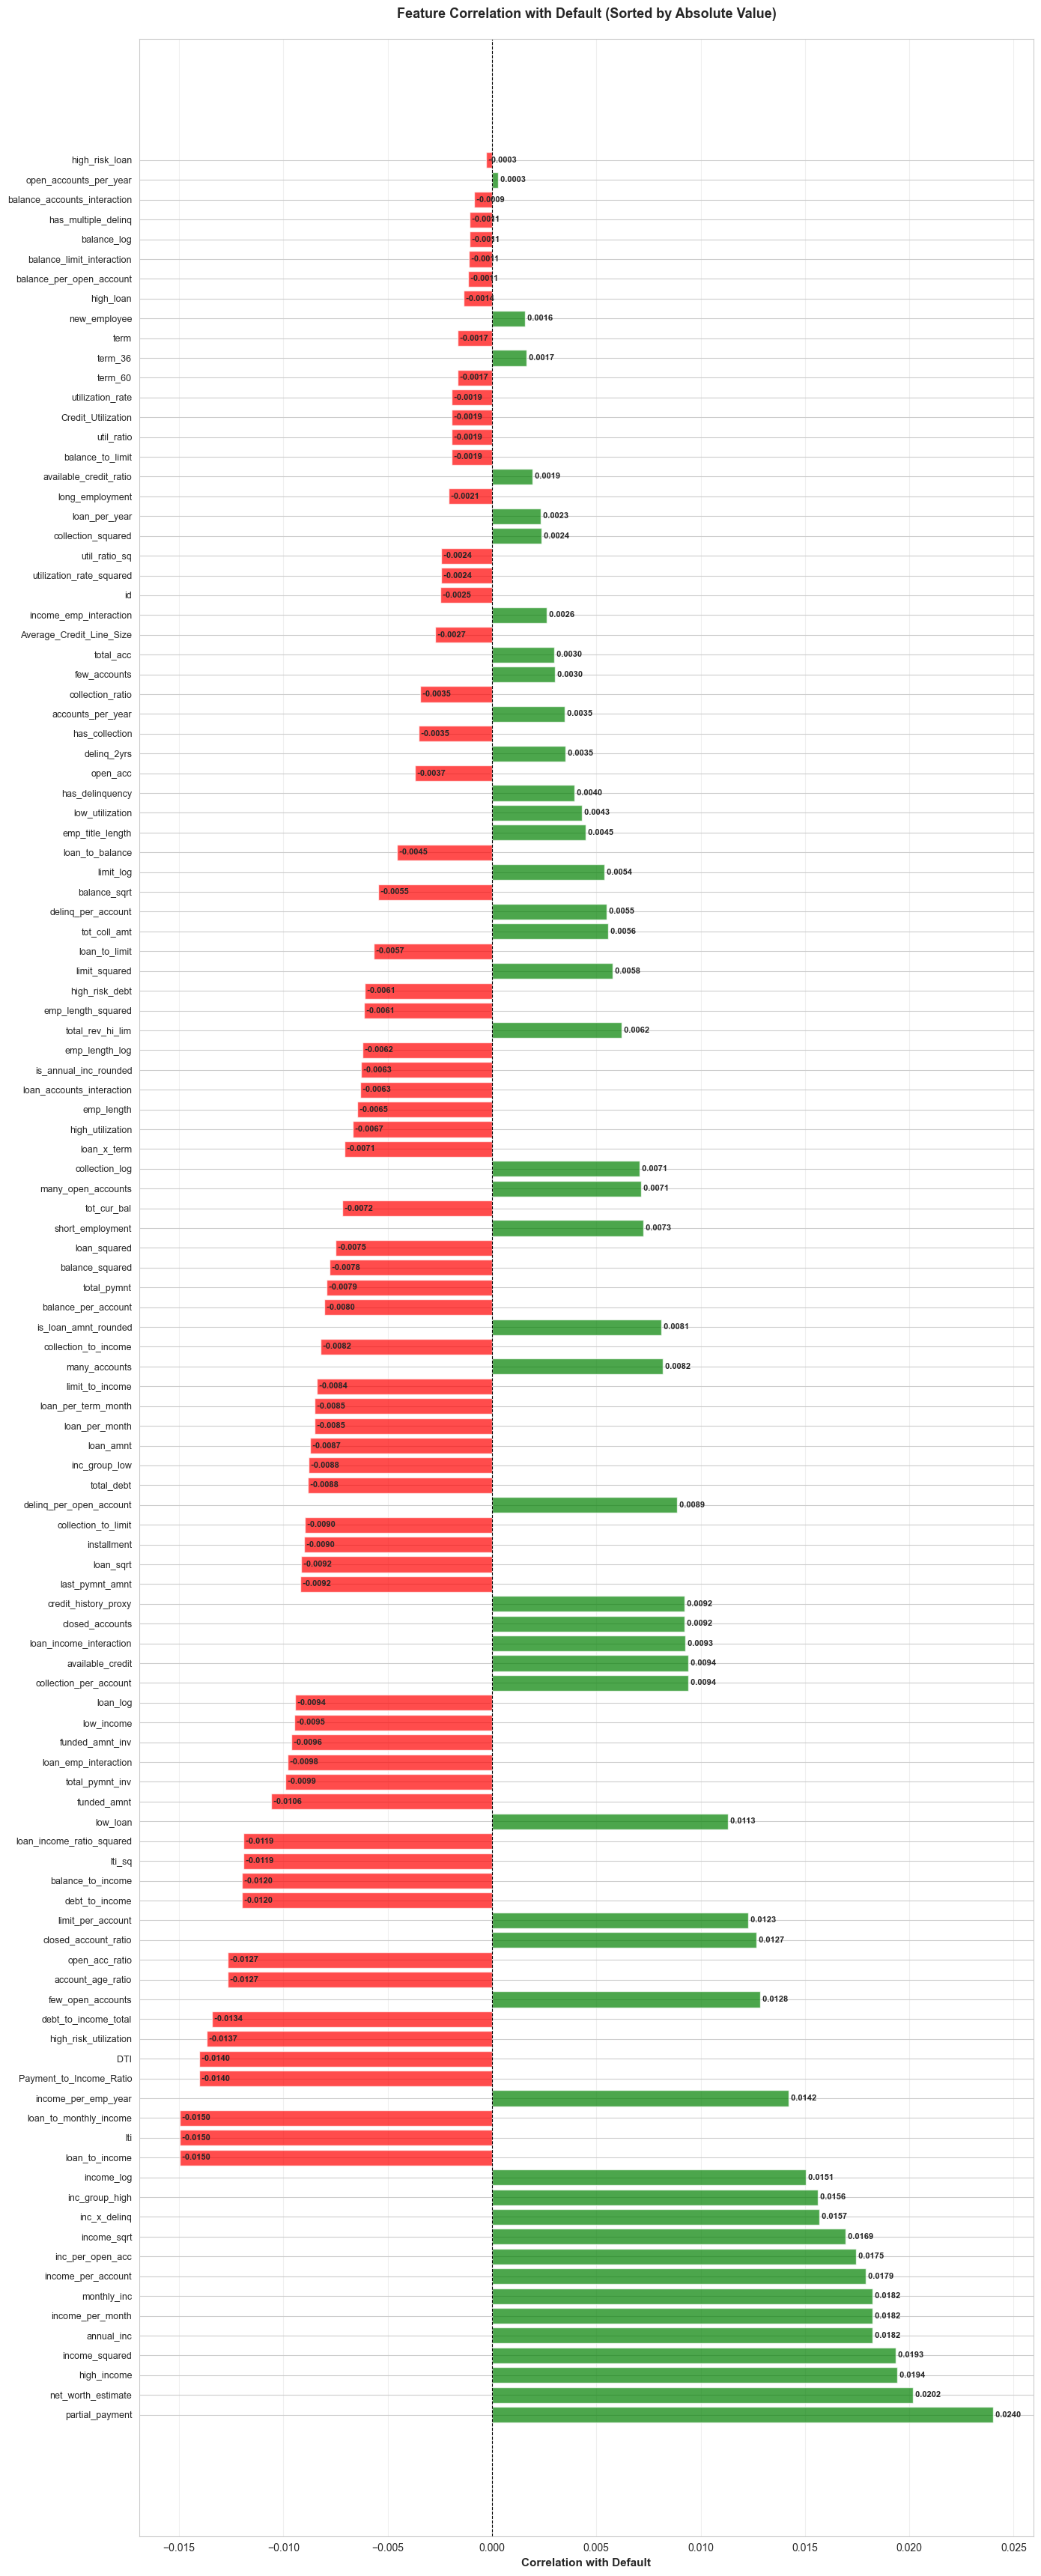


CORRELATION WITH DEFAULT (sorted by absolute value)
partial_payment                 0.024007
net_worth_estimate              0.020192
high_income                     0.019404
income_squared                  0.019337
annual_inc                      0.018248
income_per_month                0.018248
monthly_inc                     0.018248
income_per_account              0.017925
inc_per_open_acc                0.017463
income_sqrt                     0.016932
inc_x_delinq                    0.015691
inc_group_high                  0.015632
income_log                      0.015051
loan_to_income                 -0.014959
lti                            -0.014959
loan_to_monthly_income         -0.014959
income_per_emp_year             0.014219
Payment_to_Income_Ratio        -0.014032
DTI                            -0.014032
high_risk_utilization          -0.013671
debt_to_income_total           -0.013438
few_open_accounts               0.012844
account_age_ratio              -0.012684
open

In [15]:
numeric_features_all = df_viz_eng.select_dtypes(include=[np.number]).columns.tolist()
if 'default' in numeric_features_all:
    numeric_features_all.remove('default')

corr_with_default = df_viz_eng[numeric_features_all + ['default']].corr()['default'].drop('default')
corr_with_default = corr_with_default.sort_values(key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(14, max(8, len(corr_with_default) * 0.3)))
colors = ['red' if x < 0 else 'green' for x in corr_with_default.values]
bars = ax.barh(range(len(corr_with_default)), corr_with_default.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(corr_with_default)))
ax.set_yticklabels(corr_with_default.index, fontsize=9)
ax.set_xlabel('Correlation with Default', fontsize=11, fontweight='bold')
ax.set_title('Feature Correlation with Default (Sorted by Absolute Value)', 
             fontsize=13, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax.grid(alpha=0.3, axis='x')

for i, (idx, val) in enumerate(corr_with_default.items()):
    ax.text(val, i, f' {val:.4f}', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("CORRELATION WITH DEFAULT (sorted by absolute value)")
print("=" * 80)
print(corr_with_default.to_string())

# Show top 20 features
print("\n\nTop 20 Features (by absolute correlation):")
print(corr_with_default.head(20).to_string())


### 4.2 Detailed Analysis of Engineered Features

For each engineered feature:
- Distribution by default status
- Statistical summary
- Box plots
- Histograms


Number of engineered features to analyze: 98


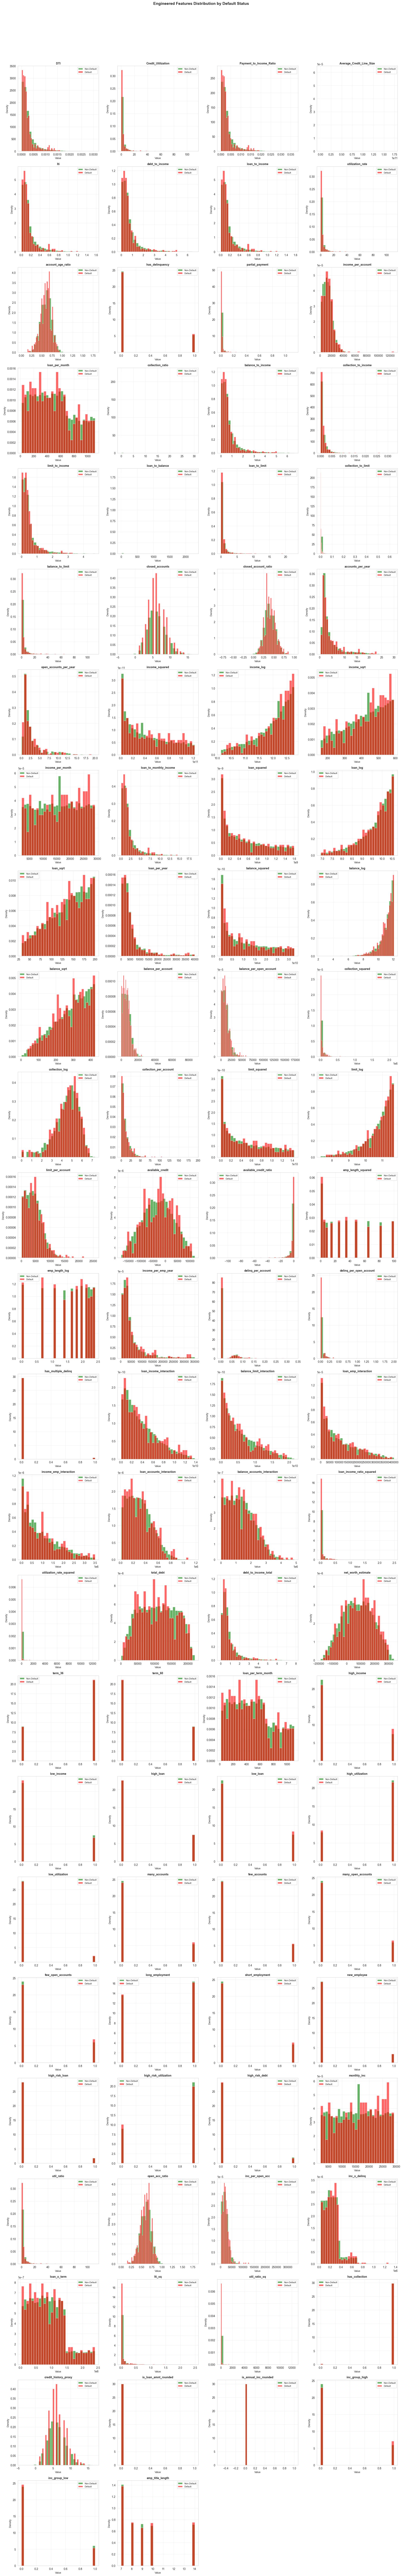

<Figure size 1200x600 with 0 Axes>

In [16]:
engineered_feature_names = [feat for feat in config.ENGINEERED_FEATURES.keys() if feat in X_eng.columns]
print(f"Number of engineered features to analyze: {len(engineered_feature_names)}")

n_features = len(engineered_feature_names)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

# Distribution plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, feat_name in enumerate(engineered_feature_names):
    ax = axes[idx]
    
    non_default_data = df_viz_eng[df_viz_eng['default'] == 0][feat_name].dropna()
    default_data = df_viz_eng[df_viz_eng['default'] == 1][feat_name].dropna()
    
    # Histogram
    ax.hist(non_default_data, bins=30, alpha=0.6, label='Non-Default', color='green', density=True)
    ax.hist(default_data, bins=30, alpha=0.6, label='Default', color='red', density=True)
    ax.set_title(f'{feat_name}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Value', fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

for idx in range(len(engineered_feature_names), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Engineered Features Distribution by Default Status', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
plt.savefig('plots/feature_engineering_test_distribution.png')


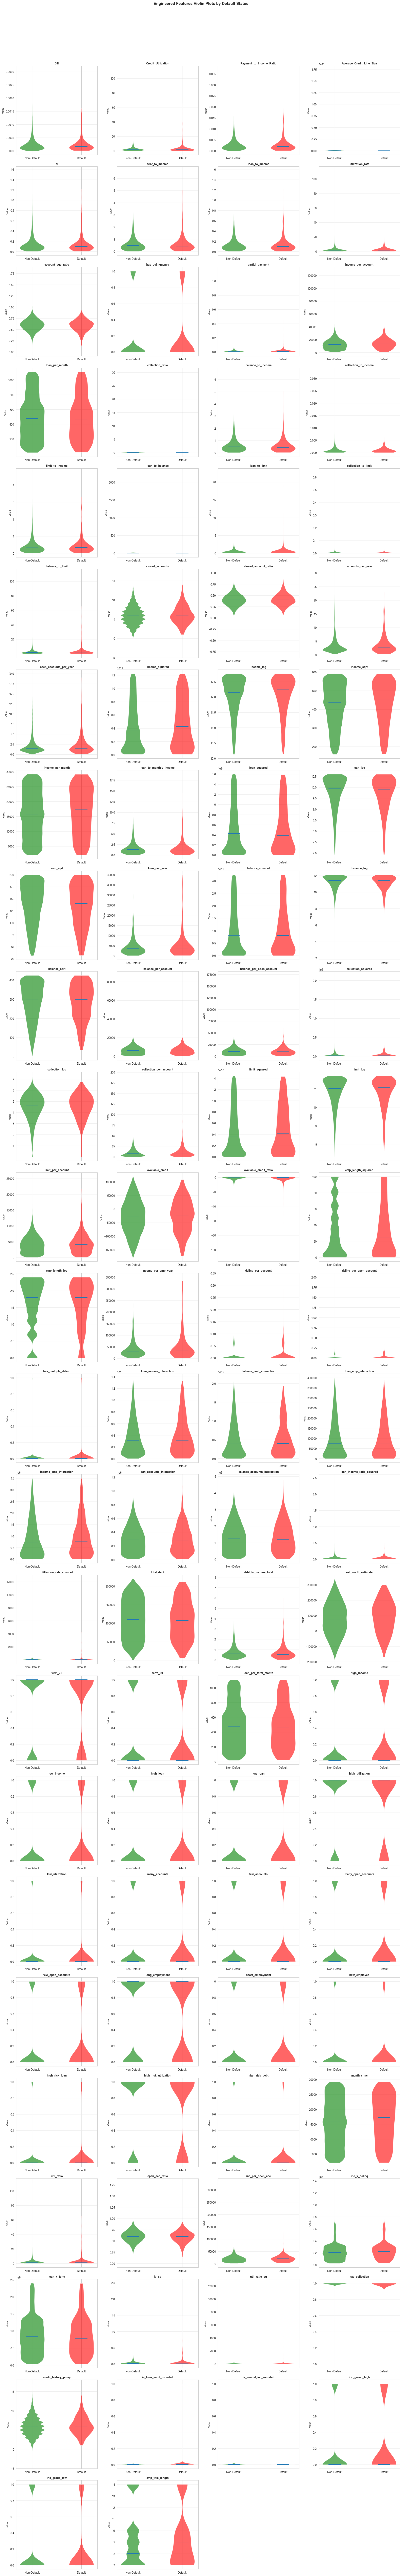

<Figure size 1200x600 with 0 Axes>

In [17]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, feat_name in enumerate(engineered_feature_names):
    ax = axes[idx]
    
    non_default_data = df_viz_eng[df_viz_eng['default'] == 0][feat_name].dropna()
    default_data = df_viz_eng[df_viz_eng['default'] == 1][feat_name].dropna()
    
    vp = ax.violinplot(
        [non_default_data, default_data],
        showmeans=False,
        showextrema=False,
        showmedians=True
    )
    
    for i, body in enumerate(vp['bodies']):
        if i == 0:
            body.set_facecolor('green')     # Non-default
        else:
            body.set_facecolor('red')       # Default
        body.set_alpha(0.6)

    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Non-Default', 'Default'])
    ax.set_title(f'{feat_name}', fontsize=10, fontweight='bold')
    ax.set_ylabel('Value', fontsize=9)
    ax.grid(alpha=0.3, axis='y')

# Extra boş subplotları kapat
for idx in range(len(engineered_feature_names), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Engineered Features Violin Plots by Default Status',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
plt.savefig('plots/feature_engineering_test_violin_plots.png')


ENGINEERED FEATURES STATISTICAL SUMMARY BY DEFAULT STATUS

Statistical Summary (sorted by Effect Size):


Feature  Non-Default_Mean  Default_Mean  \
10               partial_payment      1.401775e-02  1.827981e-02   
63            net_worth_estimate      7.755059e+04  9.023443e+04   
67                   high_income      2.485223e-01  2.977778e-01   
25                income_squared      4.394518e+10  4.799323e+10   
28              income_per_month      1.566379e+04  1.649159e+04   
..                           ...               ...           ...   
52           has_multiple_delinq      1.635739e-02  1.555556e-02   
35                   balance_log      1.110360e+01  1.109733e+01   
58  balance_accounts_interaction      1.352238e+06  1.347780e+06   
24        open_accounts_per_year      2.509050e+00  2.513741e+00   
80                high_risk_loan      6.041237e-02  6.000000e-02   

    Non-Default_Median  Default_Median  Non-Default_Std   Default_Std  \
10        5.729074e-03    6.173036e-03     2.977401e-02  4.356313e-02   
63        7.725800e+04    9.766900e+04     1.072040e+05  1.051468e+05   
67        0.000000e+00    0.000000e+00     4.321711e-01  4.577902e-01   
25        3.577091e+10    4.275736e+10     3.568106e+10  3.655312e+10   
28        1.576100e+04    1.723154e+04     7.734644e+03  7.839031e+03   
..                 ...             ...              ...           ...   
52        0.000000e+00    0.000000e+00     1.268500e-01  1.238858e-01   
35        1.140883e+01    1.140000e+01     9.921849e-01  9.179632e-01   
58        1.264643e+06    1.172776e+06     8.730588e+05  9.075049e+05   
24        1.500000e+00    1.500000e+00     2.638989e+00  2.564351e+00   
80        0.000000e+00    0.000000e+00     2.382575e-01  2.377512e-01   

       Mean_Diff  Effect_Size  Correlation  
10  4.262057e-03     0.143147     0.024007  
63  1.268384e+04     0.118315     0.020192  
67  4.925544e-02     0.113972     0.019404  
25  4.048059e+09     0.113451     0.019337  
28  8.278016e+02     0.107025     0.018248  
..           ...          ...          ...  
52 -8.018328e-04    -0.006321    -0.001079  
35 -6.270887e-03    -0.006320    -0.001081  
58 -4.457407e+03    -0.005106    -0.000870  
24  4.690246e-03     0.001777     0.000303  
80 -4.123711e-04    -0.001731    -0.000295  

[98 rows x 10 columns]

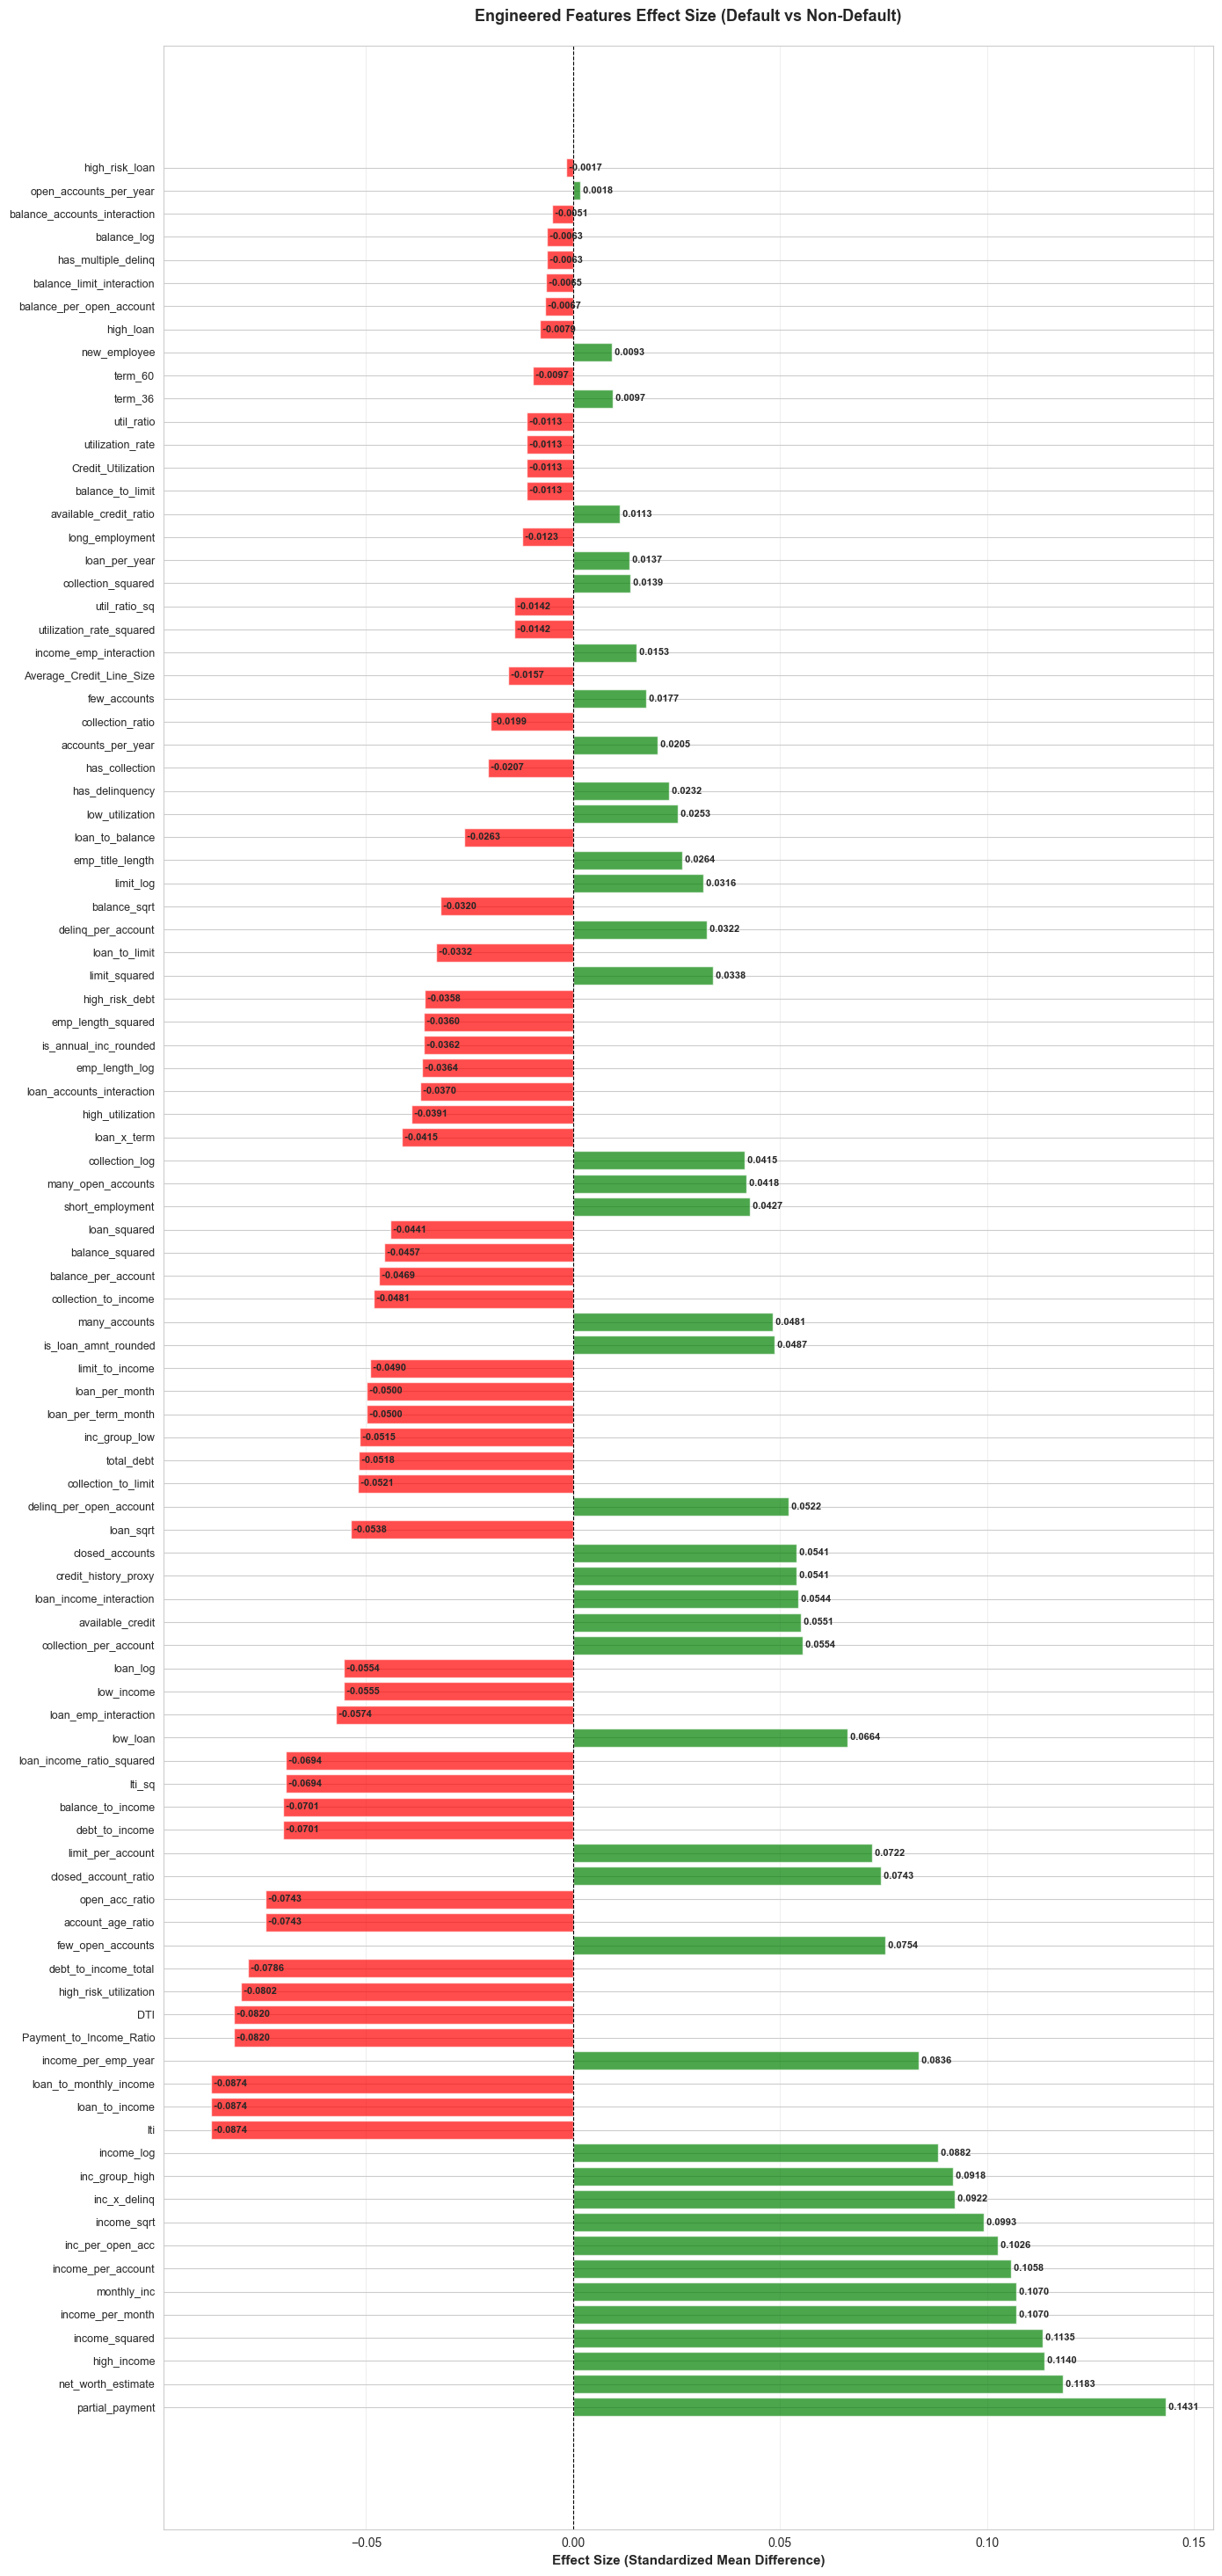

<Figure size 1200x600 with 0 Axes>

In [18]:
print("=" * 80)
print("ENGINEERED FEATURES STATISTICAL SUMMARY BY DEFAULT STATUS")
print("=" * 80)

summary_stats = []
for feat_name in engineered_feature_names:
    non_default = df_viz_eng[df_viz_eng['default'] == 0][feat_name].dropna()
    default = df_viz_eng[df_viz_eng['default'] == 1][feat_name].dropna()
    
    stats = {
        'Feature': feat_name,
        'Non-Default_Mean': non_default.mean(),
        'Default_Mean': default.mean(),
        'Non-Default_Median': non_default.median(),
        'Default_Median': default.median(),
        'Non-Default_Std': non_default.std(),
        'Default_Std': default.std(),
        'Mean_Diff': default.mean() - non_default.mean(),
        'Effect_Size': (default.mean() - non_default.mean()) / non_default.std() if non_default.std() > 0 else 0,
        'Correlation': corr_with_default.get(feat_name, 0)
    }
    summary_stats.append(stats)

stats_df = pd.DataFrame(summary_stats)
stats_df = stats_df.sort_values('Effect_Size', key=abs, ascending=False)

print("\nStatistical Summary (sorted by Effect Size):")
display(stats_df)

# Visualize effect sizes
fig, ax = plt.subplots(figsize=(14, max(8, len(engineered_feature_names) * 0.3)))
colors = ['red' if x < 0 else 'green' for x in stats_df['Effect_Size'].values]
bars = ax.barh(range(len(stats_df)), stats_df['Effect_Size'].values, color=colors, alpha=0.7)
ax.set_yticks(range(len(stats_df)))
ax.set_yticklabels(stats_df['Feature'].values, fontsize=9)
ax.set_xlabel('Effect Size (Standardized Mean Difference)', fontsize=11, fontweight='bold')
ax.set_title('Engineered Features Effect Size (Default vs Non-Default)', 
             fontsize=13, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax.grid(alpha=0.3, axis='x')

# Add value labels
for i, val in enumerate(stats_df['Effect_Size'].values):
    ax.text(val, i, f' {val:.4f}', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig('plots/feature_engineering_test_effect_sizes.png')


### 4.3 Feature Correlation Matrix (Engineered Features Only)


### 4.4 Feature Value Ranges and Outliers

Value ranges and outlier analysis for each engineered feature.


FEATURE VALUE RANGES AND OUTLIER ANALYSIS

Feature Value Ranges and Outlier Statistics:


Feature           Min           Q1    Median            Q3  \
69              high_loan      0.000000       0.0000       0.0  2.500000e-01   
68             low_income      0.000000       0.0000       0.0  2.500000e-01   
67            high_income      0.000000       0.0000       0.0  2.500000e-01   
70               low_loan      0.000000       0.0000       0.0  0.000000e+00   
76      few_open_accounts      0.000000       0.0000       0.0  0.000000e+00   
..                    ...           ...          ...       ...           ...   
71       high_utilization      0.000000       0.0000       1.0  1.000000e+00   
81  high_risk_utilization      0.000000       0.0000       1.0  1.000000e+00   
83            monthly_inc   2083.583333    9086.5625   15761.0  2.225598e+04   
88            loan_x_term  36072.000000  439245.0000  832320.0  1.233597e+06   
97       emp_title_length      7.000000       7.0000       8.0  1.000000e+01   

           Max           Mean            Std  Outliers  Outlier_Pct  Has_Inf  \
69        1.00       0.250000       0.433027      3750    25.000000    False   
68        1.00       0.250000       0.433027      3750    25.000000    False   
67        1.00       0.250000       0.433027      3750    25.000000    False   
70        1.00       0.249933       0.432989      3749    24.993333    False   
76        1.00       0.201800       0.401357      3027    20.180000    False   
..         ...            ...            ...       ...          ...      ...   
71        1.00       0.734533       0.441596         0     0.000000    False   
81        1.00       0.700067       0.458244         0     0.000000    False   
83    29164.25   15688.621300    7738.819826         0     0.000000    False   
88  2399820.00  882573.748800  547664.358766         0     0.000000    False   
97       14.00       9.169467       2.409661         0     0.000000    False   

    Has_NaN  
69    False  
68    False  
67    False  
70    False  
76    False  
..      ...  
71    False  
81    False  
83    False  
88    False  
97    False  

[98 rows x 12 columns]

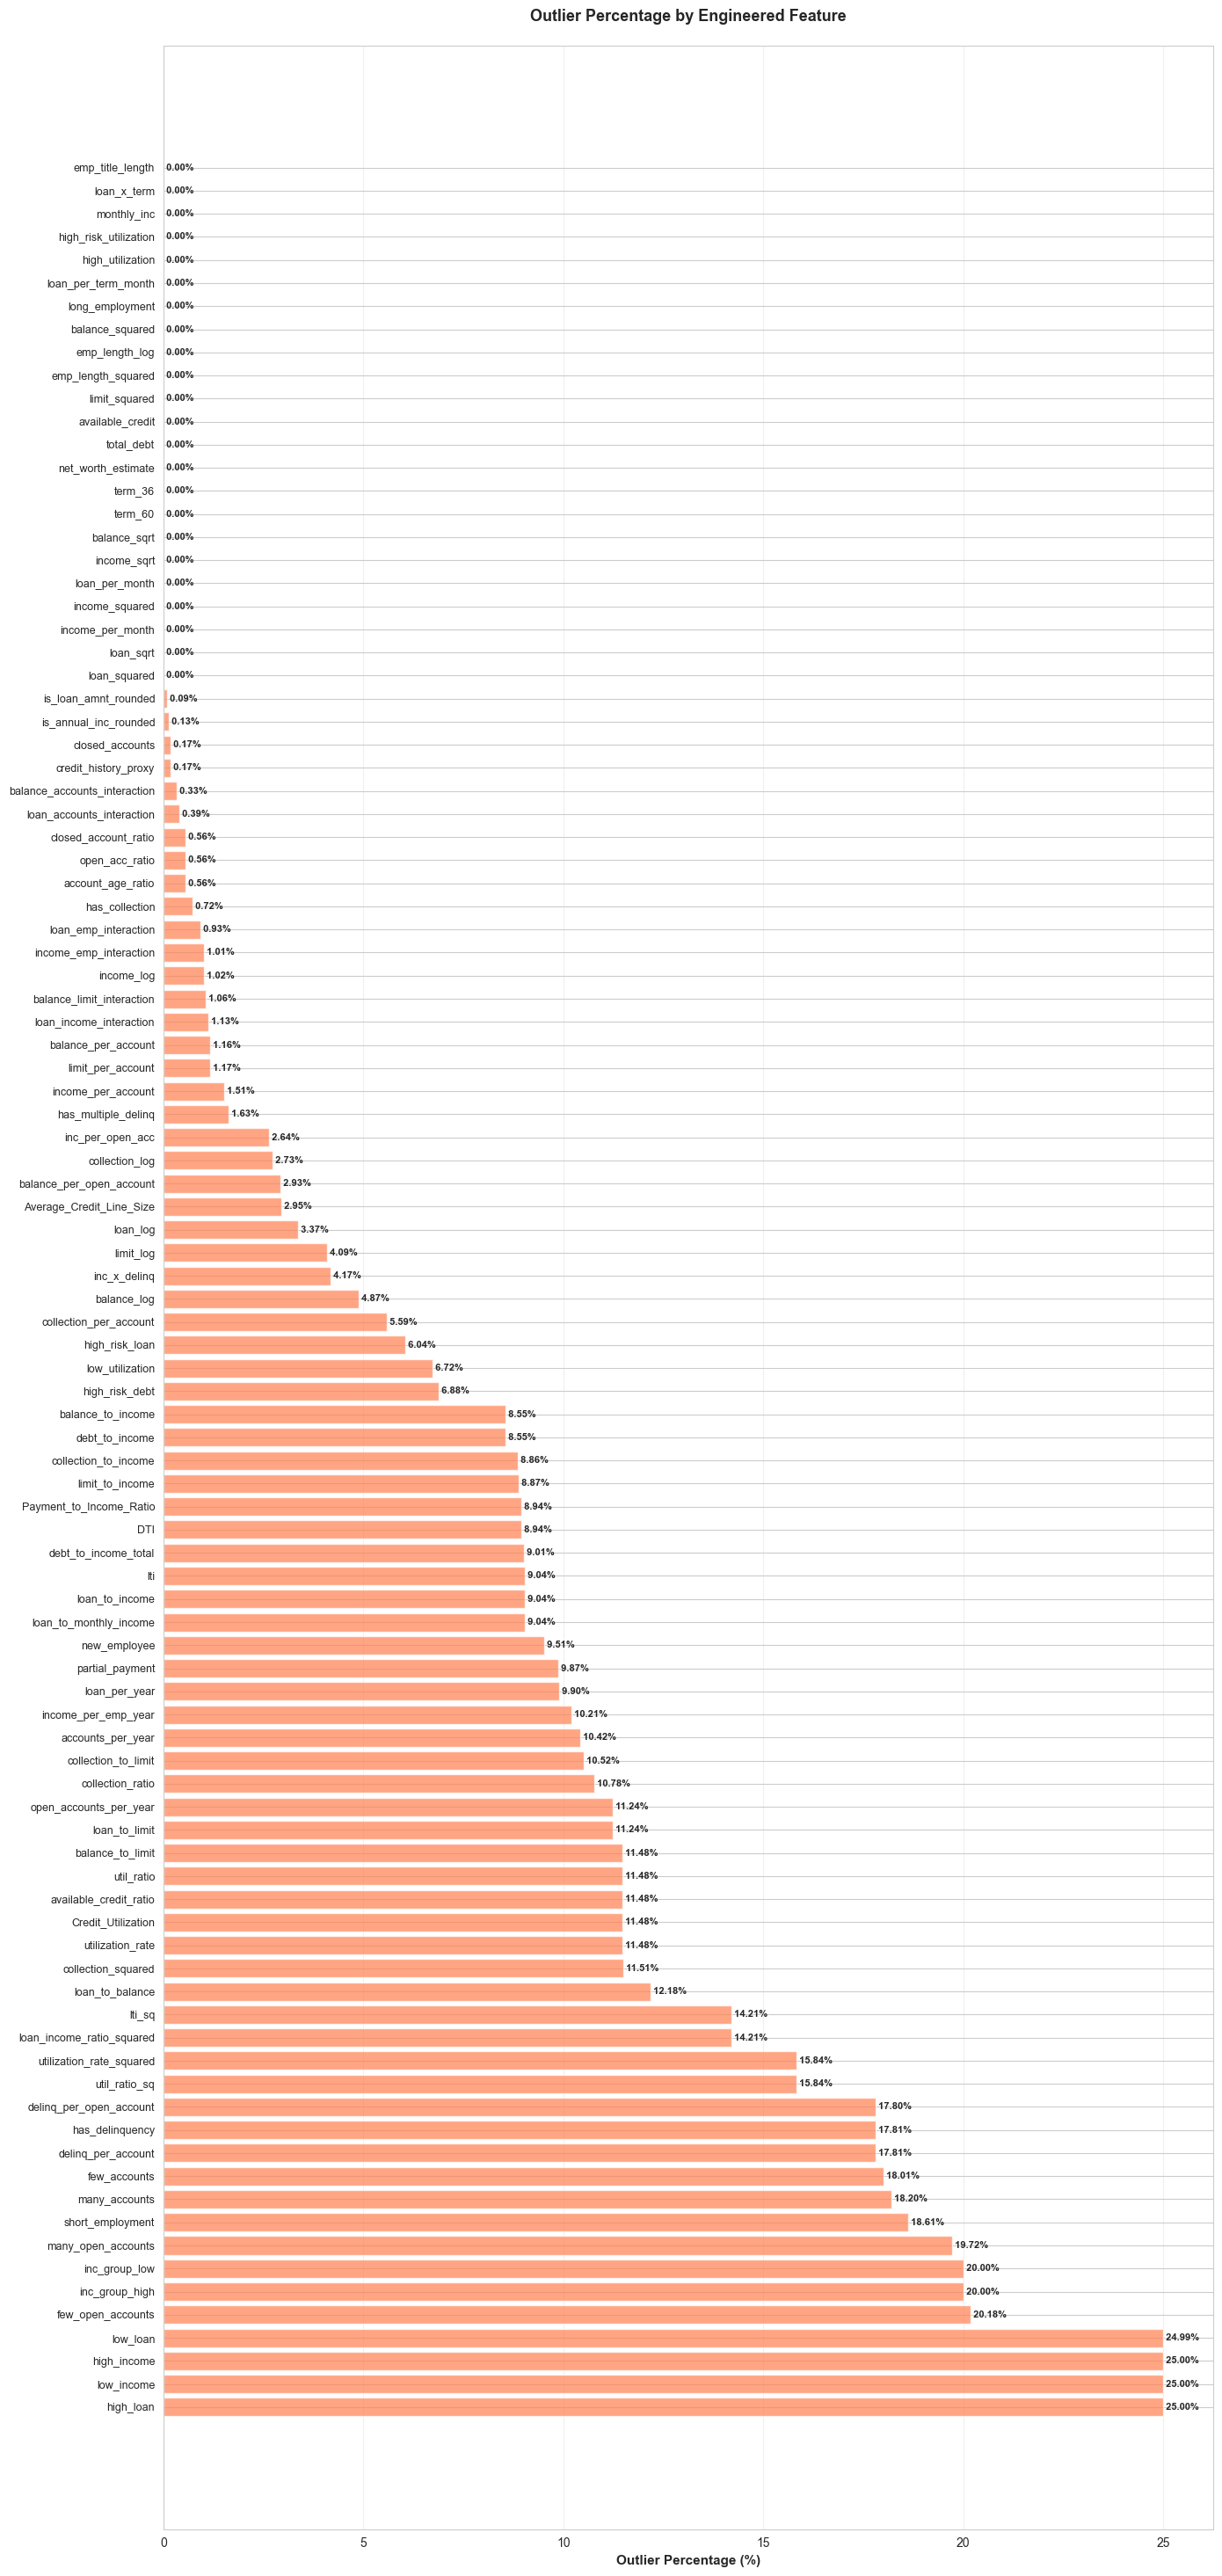

In [19]:
# Feature value ranges and outlier analysis
print("=" * 80)
print("FEATURE VALUE RANGES AND OUTLIER ANALYSIS")
print("=" * 80)

feature_ranges = []
for feat_name in engineered_feature_names:
    if feat_name not in df_viz_eng.columns:
        continue
    
    data = df_viz_eng[feat_name].dropna()
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    outlier_pct = (outliers / len(data)) * 100
    
    range_info = {
        'Feature': feat_name,
        'Min': data.min(),
        'Q1': Q1,
        'Median': data.median(),
        'Q3': Q3,
        'Max': data.max(),
        'Mean': data.mean(),
        'Std': data.std(),
        'Outliers': outliers,
        'Outlier_Pct': outlier_pct,
        'Has_Inf': np.isinf(data).any(),
        'Has_NaN': data.isna().any()
    }
    feature_ranges.append(range_info)

ranges_df = pd.DataFrame(feature_ranges)
ranges_df = ranges_df.sort_values('Outlier_Pct', ascending=False)

print("\nFeature Value Ranges and Outlier Statistics:")
display(ranges_df)

# Visualize outlier percentages
fig, ax = plt.subplots(figsize=(14, max(8, len(engineered_feature_names) * 0.3)))
bars = ax.barh(range(len(ranges_df)), ranges_df['Outlier_Pct'].values, 
               color='coral', alpha=0.7)
ax.set_yticks(range(len(ranges_df)))
ax.set_yticklabels(ranges_df['Feature'].values, fontsize=9)
ax.set_xlabel('Outlier Percentage (%)', fontsize=11, fontweight='bold')
ax.set_title('Outlier Percentage by Engineered Feature', 
             fontsize=13, fontweight='bold', pad=20)
ax.grid(alpha=0.3, axis='x')

# Add value labels
for i, val in enumerate(ranges_df['Outlier_Pct'].values):
    ax.text(val, i, f' {val:.2f}%', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


### 4.5 Top Features by Importance

Features with highest correlation with default.


TOP 20 FEATURES BY ABSOLUTE CORRELATION WITH DEFAULT


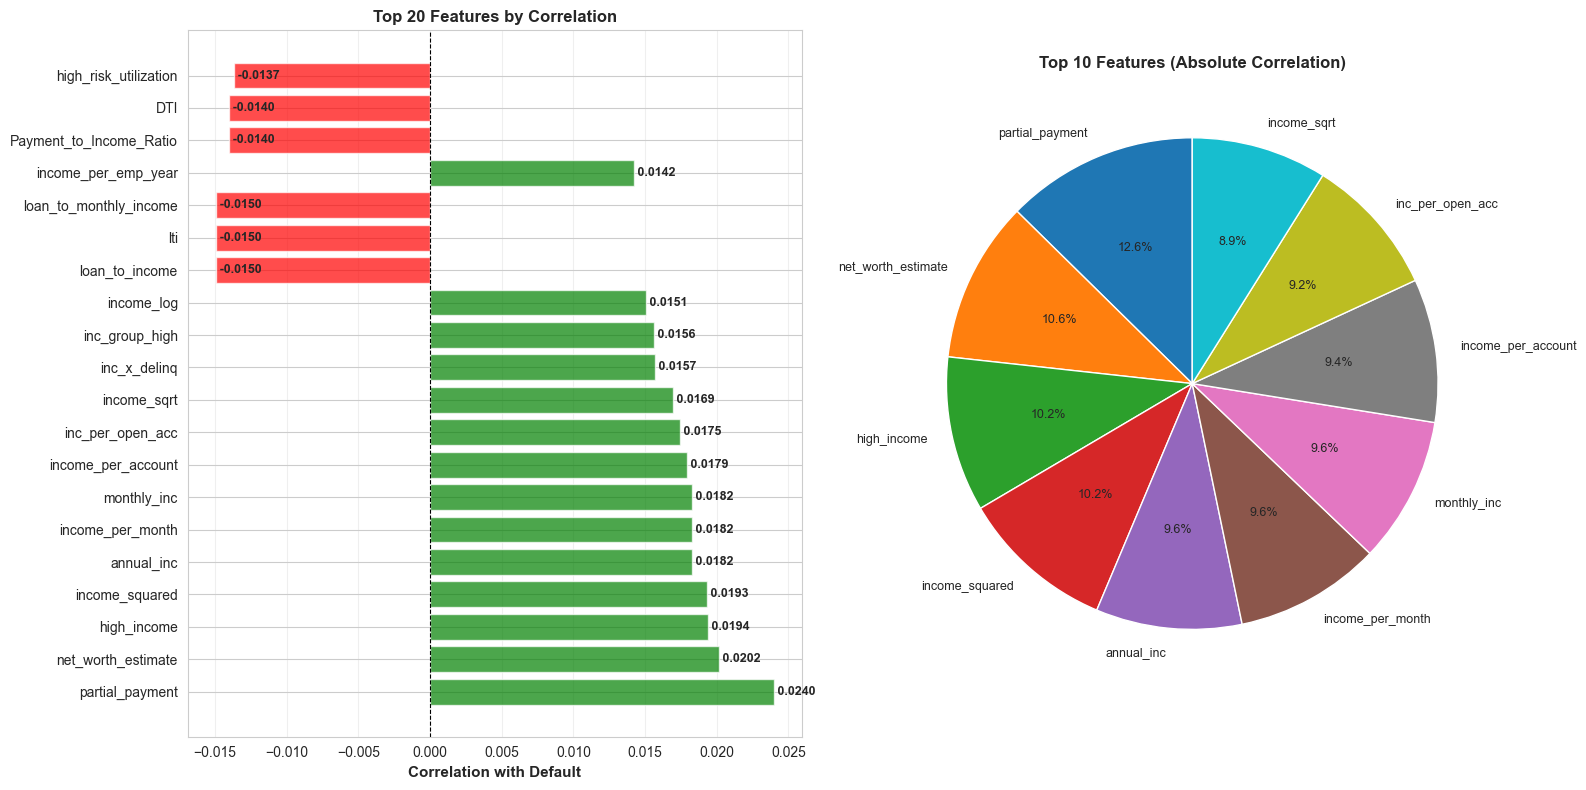


Top Features Table:
partial_payment            0.024007
net_worth_estimate         0.020192
high_income                0.019404
income_squared             0.019337
annual_inc                 0.018248
income_per_month           0.018248
monthly_inc                0.018248
income_per_account         0.017925
inc_per_open_acc           0.017463
income_sqrt                0.016932
inc_x_delinq               0.015691
inc_group_high             0.015632
income_log                 0.015051
loan_to_income            -0.014959
lti                       -0.014959
loan_to_monthly_income    -0.014959
income_per_emp_year        0.014219
Payment_to_Income_Ratio   -0.014032
DTI                       -0.014032
high_risk_utilization     -0.013671


In [20]:
# Top features by absolute correlation with default
top_n = 20
top_features = corr_with_default.head(top_n)

print("=" * 80)
print(f"TOP {top_n} FEATURES BY ABSOLUTE CORRELATION WITH DEFAULT")
print("=" * 80)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

colors = ['red' if x < 0 else 'green' for x in top_features.values]
axes[0].barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features.index, fontsize=10)
axes[0].set_xlabel('Correlation with Default', fontsize=11, fontweight='bold')
axes[0].set_title(f'Top {top_n} Features by Correlation', fontsize=12, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].grid(alpha=0.3, axis='x')

# Add value labels
for i, (idx, val) in enumerate(top_features.items()):
    axes[0].text(val, i, f' {val:.4f}', va='center', fontsize=9, fontweight='bold')

# Pie chart for top 10
top_10 = top_features.head(10)
top_10_abs = top_10.abs()
axes[1].pie(top_10_abs.values, labels=top_10.index, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 9})
axes[1].set_title('Top 10 Features (Absolute Correlation)', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print table
print("\nTop Features Table:")
print(top_features.to_string())


## 5. Summary and Results

Test results for all engineered features.


In [21]:
print("=" * 80)
print("FEATURE ENGINEERING TEST SUMMARY")
print("=" * 80)

print(f"\n1. Data Cleaning:")
print(f"Original number of columns: {df_raw.shape[1] - 1}")
print(f"Cleaned number of columns: {X.shape[1]} (no columns dropped)")
print(f"Missing value handling: completed")
print(f"Business constraints: applied")

print(f"\n2. Feature Engineering:")
print(f"Total features in config: {len(config.ENGINEERED_FEATURES)}")
print(f"Successfully created features: {len(engineered_feature_names)}")
print(f"Final total number of features: {X_eng.shape[1]}")

print(f"\n3. Feature Analysis:")
print(f"Highest correlation (with default): {corr_with_default.iloc[0]:.4f} ({corr_with_default.index[0]})")
print(f"Lowest correlation (with default): {corr_with_default.iloc[-1]:.4f} ({corr_with_default.index[-1]})")
print(f"Average absolute correlation: {corr_with_default.abs().mean():.4f}")

print(f"\n4. Top 5 Features (by absolute correlation):")
for i, (feat, corr) in enumerate(corr_with_default.head(5).items(), 1):
    print(f"{i}. {feat}: {corr:.4f}")

print(f"\n5. Visualizations:")
print(f"Distribution plots: completed")
print(f"Box plots: completed")
print(f"Correlation heatmaps: completed")
print(f"Statistical summaries: completed")
print(f"Outlier analysis: completed")

print(f"\nTest completed!")


FEATURE ENGINEERING TEST SUMMARY

1. Data Cleaning:
Original number of columns: 19
Cleaned number of columns: 19 (no columns dropped)
Missing value handling: completed
Business constraints: applied

2. Feature Engineering:
Total features in config: 98
Successfully created features: 98
Final total number of features: 117

3. Feature Analysis:
Highest correlation (with default): 0.0240 (partial_payment)
Lowest correlation (with default): -0.0003 (high_risk_loan)
Average absolute correlation: 0.0081

4. Top 5 Features (by absolute correlation):
1. partial_payment: 0.0240
2. net_worth_estimate: 0.0202
3. high_income: 0.0194
4. income_squared: 0.0193
5. annual_inc: 0.0182

5. Visualizations:
Distribution plots: completed
Box plots: completed
Correlation heatmaps: completed
Statistical summaries: completed
Outlier analysis: completed

Test completed!
